## COMP5625M Practical Assessment - Deep Learning [100 Marks]


<div class="logos"><img src="Comp5625M_logo.jpg" width="220px" align="right"></div>

This assessment is divided into two parts:
> 1. Image classification using DNN and CNN [70 Marks]
> 2. Use of RNN to predict texts for image captioning [30 Marks]

The maximum number of marks for each part is shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 50% of the final grade for the module.


### Motivation 

Through this coursework, you will:

> 1. Understand and implement your first deep neural network and convolutional neural network (CNN) and see how these can be used for classification problem 
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage. 
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle
> 5. Use RNNs to predict the caption of an image from established word vocabularies
> 6. Understand and visualise text predictions for a given image.


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


Your student username (for example, ```sc15jb```): 

--> double click to respond

Your full name: 

--> double click to respond

### Part I: Image Classification [70 marks]

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[To submit your results on the Kaggle competition. You can also access data here](https://www.kaggle.com/t/9105198471a3490d9057026d27d8a711)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb`` (see the ``note`` below)

``Note:`` If the name is already taken in the Kaggle then please use a similar pseudo name and add a note in your submission with the name you have used in the Kaggle. 

#### Submitting your test result to Kaggle leaderboard 
The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. More information is provided in the related section below.


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed some examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [21]:
import cv2
import math
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
from torchvision.datasets import ImageFolder
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from sklearn.metrics import roc_curve
from sklearn.metrics import auc








from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Check PyTorch version
print(torch.__version__)

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print('Using device:', mps_device)
else:
    device = torch.device("cpu")
    print('Using device:', device)


2.2.0
Using device: mps


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview of image classification:**

**1. Function implementation** [14 marks]

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (6 marks)

**2. Model training** [30 marks]
*   **2.1** Training on TinyImageNet30 dataset (6 marks)
*   **2.2** Generating confusion matrices and ROC curves (6 marks)
*   **2.3** Strategies for tackling overfitting (18 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** [10 marks]
*   **3.1**   Testing your final model in (2) on test set - code to do this (4 marks)
*   **3.2**   Uploading your result to Kaggle  (6 marks)

**4. Model Fine-tuning on CIFAR10 dataset** [16 marks]
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) (6 marks)
*   **4.2** Fine-tuning model with frozen base convolution layers (6 marks)
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. (4 marks) 


<!-- **5. Model comparison** [16 marks]
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (8 marks)
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks) -->
<!-- 
**6. Interpretation of results** (14 marks)
*   **6.1** Implement grad-CAM for your model and AlexNet (6 marks)
*   **6.2** Visualise and compare your results from your model and AlexNet (4 marks)
*   **6.3** Provide comment on (4 marks)
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

**7. Residual connection for deeper network** (9 marks)
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. (6 marks)
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) (3 marks)

**Quality of your report** (2 marks) -->


## 1 Function implementations [14 marks]


### 1.1 Dataset class (4 marks)

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [3]:
# path to training data set
ROOT = os.getcwd() + "/"
DATA_DIR = ROOT + "train_set/train_set/"
CLASS_TXT_LABELS = ['baboon', 'banana', 'bee', 'bison', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 
                    'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod',
                   'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda',
                   'refrigerator', 'sombrero', 'umbrella']

# Dataset class for TinyImage30
class LoadTinyImage30TrainSet(ImageFolder):
    def __init__(
        self, 
        root: str = DATA_DIR,
        transform = transforms.ToTensor()
    ):
        super(LoadTinyImage30TrainSet, self).__init__(root=root,transform=transform)
        
    def __len__(self):
        return len(self.imgs)

# Show the image found in Helper.py
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa


In [4]:
# load the TinyImage30 dataset
train_set = LoadTinyImage30TrainSet()
validation_set = LoadTinyImage30TrainSet()

# handle partitioning of train & validation sets 
num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train)) # 20 % used for validation

np.random.seed(0) # with shuffle seed 0 for reproducability
np.random.shuffle(indices)

train_idx, validation_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx) 

number of training set images: 10816
number of validation set images: 2752


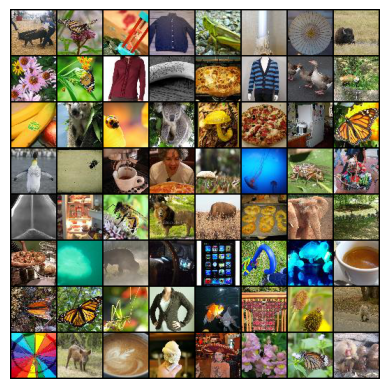

In [5]:
# adjust appropriately depending on GPU resources available / size of problem to speed up training
BATCH_SIZE = 64
# adjust appropriately depending on CPU architecture to speed-up loading
NUM_WORKERS = 0

# the training set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

# validation set
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE,  
                          num_workers=NUM_WORKERS, sampler=validation_sampler)

# by confirming size of partitions after loading
print("number of training set images: " + str(len(train_loader)*BATCH_SIZE))
print("number of validation set images: " + str(len(validation_loader)*BATCH_SIZE))

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images and labels
_ = timshow(torchvision.utils.make_grid(images))

### 1.2 Define a MLP model class (4 marks)

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [6]:
# define a MLP Model class https://pytorch.org/vision/main/generated/torchvision.ops.MLP.html
#Reminder tiny image 30 has 30 class labels and is made up of 64 *64 images with 3 color channels 

class MLPClassifier(nn.Module):
    
    def __init__(self, num_classes=30):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,30)
        
    def forward(self, x):
        out = torch.flatten(x, 1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
mlp_net = MLPClassifier()
mlp_loss_fn = nn.CrossEntropyLoss()
mlp_optimizer = optim.SGD(mlp_net.parameters(), lr=0.01, momentum=0.9)
print(mlp_net)

MLPClassifier(
  (fc1): Linear(in_features=12288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


### 1.3 Define a CNN model class (6 marks)

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [7]:

# define a CNN Model class
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class CNNClassifier(nn.Module):
    
    def __init__(self, num_classes=30):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=40,kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=40,out_channels=80,kernel_size=3)
        self.fc1 = nn.Linear(15680, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
cnn_net = CNNClassifier()
cnn_loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = optim.SGD(cnn_net.parameters(), lr=0.01, momentum=0.9)
print(cnn_net) 

CNNClassifier(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


## 2 Model training [30 marks]


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side (6 marks)

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [8]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [9]:
#TO COMPLETE --> Running your MLP model class
def train_model(nepochs: int, model, loss_fn, optimizer, root_path: str, file_name: str):
    if torch.cuda.is_available(): # load the network in GPU if available
        model = model.cuda()
        
    max_validation_acc = np.NINF
    statsrec = np.zeros((4,nepochs)) # record stats for testing & validation

    for epoch in range(nepochs):  # loop over the dataset multiple times
        train_loss = 0.0   # accumulated loss
        train_acc = 0.0    # accumulated accuracy
        n = 0 # batch counter for averaging accumulated values

        for data, labels in train_loader:
            if torch.cuda.is_available(): # load the data in GPU if available
                data, labels = data.cuda(), labels.cuda()
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward, backward, and update parameters
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # accumulate loss
            train_loss += loss.item()
            # accumulate topk accuracy
            train_acc += torch.tensor(topk_accuracy(outputs, labels), device = 'cpu').item()
            n += 1
     
        # collect together statistics for this epoch (take the mean across all batches)
        train_loss = train_loss/n
        train_acc = train_acc/n

        print(f"Epoch {epoch} \t\t training loss: {train_loss: .3f}")
        print(f"Epoch {epoch} \t\t training topk accuracy: {train_acc: .3f}")

        # accumulate loss & accuracy for validation
        validation_loss = 0.0
        validation_acc = 0.0
        n = 0
        # evaluate, e.g. do not compute gradients for validation
        model.eval()
        for data, labels in validation_loader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            output = model(data)
            loss = loss_fn(output,labels)
            validation_loss += loss.item()
            validation_acc += torch.tensor(topk_accuracy(output, labels), device = 'cpu').item()
            n += 1

        # average the accumulated values
        validation_loss = validation_loss / n
        validation_acc = validation_acc / n
        # record the stats for this epoch
        statsrec[:,epoch] = (train_loss, train_acc, validation_loss, validation_acc)
        
        # update new maximum
        if validation_acc > max_validation_acc:  
            max_validation_acc = validation_acc
            # save network parameters, losses and accuracy to 
            # specified path when validation acc is at maximum
            optimal_path = os.path.join(root_path, "results/optimal_" + file_name + ".pt")
            os.makedirs(os.path.dirname(optimal_path), exist_ok=True)  # Create parent directories if they don't exist
            torch.save({"state_dict": model.state_dict(), "stats": statsrec}, optimal_path)
            print(f"Epoch {epoch} \t\t new validation accuracy maximum {validation_acc: .3f}")
        
        # save the sub-optimal network as well to plot graph for Section (2.1)
        results_path = os.path.join(root_path, "results", file_name + ".pt")
        os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Create parent directories if they don't exist
        torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)

# Adjust the root path accordingly in the train_model function
train_model(100, mlp_net, mlp_loss_fn, mlp_optimizer, ROOT, "mlpclassifier")


Epoch 0 		 training loss:  3.271
Epoch 0 		 training topk accuracy:  8.096
Epoch 0 		 new validation accuracy maximum  10.102
Epoch 1 		 training loss:  3.030
Epoch 1 		 training topk accuracy:  13.588
Epoch 1 		 new validation accuracy maximum  14.002
Epoch 2 		 training loss:  2.909
Epoch 2 		 training topk accuracy:  16.747
Epoch 2 		 new validation accuracy maximum  15.201
Epoch 3 		 training loss:  2.829
Epoch 3 		 training topk accuracy:  18.580
Epoch 3 		 new validation accuracy maximum  16.909
Epoch 4 		 training loss:  2.776
Epoch 4 		 training topk accuracy:  19.933
Epoch 4 		 new validation accuracy maximum  20.652
Epoch 5 		 training loss:  2.727
Epoch 5 		 training topk accuracy:  21.604
Epoch 6 		 training loss:  2.678
Epoch 6 		 training topk accuracy:  23.354
Epoch 7 		 training loss:  2.615
Epoch 7 		 training topk accuracy:  24.202
Epoch 8 		 training loss:  2.604
Epoch 8 		 training topk accuracy:  24.100
Epoch 9 		 training loss:  2.545
Epoch 9 		 training topk accu

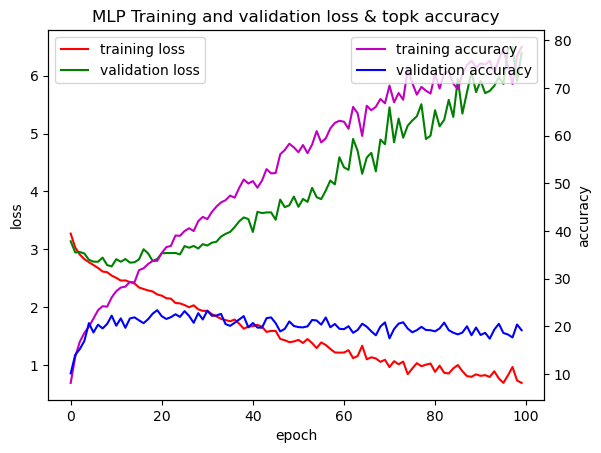

In [10]:

# Your graph
def plot_model_train_stats(results_path, 
                           fig_name: str="roc.svg", 
                           title: str="Training and validation loss & topk accuracy",
                           nepochs=None):
    data = torch.load(results_path)
    statsrec = data["stats"]
    if nepochs is not None:
        statsrec = statsrec[:, :nepochs]
        
    fig, ax1 = plt.subplots()
    ax1.plot(statsrec[0], 'r', label='training loss')
    ax1.plot(statsrec[2], 'g', label='validation loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title(title)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.plot(statsrec[1], 'm', label='training accuracy')
    ax2.plot(statsrec[3], 'b', label='validation accuracy')
    ax2.set_ylabel('accuracy')
    ax2.legend(loc='upper right')
    
    fig.savefig(fig_name)
    plt.show()

#MLP Model visualised
plot_model_train_stats(os.getcwd() + "/results/mlpclassifier.pt",
                       "roc_mlp.svg", 
                       "MLP Training and validation loss & topk accuracy")

In [11]:
#TO COMPLETE --> Running your CNN model class
train_model(100, cnn_net, cnn_loss_fn, cnn_optimizer, ROOT, "cnnclassifier")

Epoch 0 		 training loss:  3.395
Epoch 0 		 training topk accuracy:  4.151
Epoch 0 		 new validation accuracy maximum  6.444
Epoch 1 		 training loss:  3.193
Epoch 1 		 training topk accuracy:  10.389
Epoch 1 		 new validation accuracy maximum  12.670
Epoch 2 		 training loss:  3.000
Epoch 2 		 training topk accuracy:  14.361
Epoch 2 		 new validation accuracy maximum  16.473
Epoch 3 		 training loss:  2.788
Epoch 3 		 training topk accuracy:  18.149
Epoch 3 		 new validation accuracy maximum  22.178
Epoch 4 		 training loss:  2.617
Epoch 4 		 training topk accuracy:  23.135
Epoch 4 		 new validation accuracy maximum  24.830
Epoch 5 		 training loss:  2.474
Epoch 5 		 training topk accuracy:  27.093
Epoch 5 		 new validation accuracy maximum  26.587
Epoch 6 		 training loss:  2.355
Epoch 6 		 training topk accuracy:  30.843
Epoch 6 		 new validation accuracy maximum  27.907
Epoch 7 		 training loss:  2.228
Epoch 7 		 training topk accuracy:  34.360
Epoch 7 		 new validation accuracy ma

Epoch 92 		 training loss:  0.000
Epoch 92 		 training topk accuracy:  100.000
Epoch 93 		 training loss:  0.000
Epoch 93 		 training topk accuracy:  100.000
Epoch 94 		 training loss:  0.000
Epoch 94 		 training topk accuracy:  100.000
Epoch 95 		 training loss:  0.000
Epoch 95 		 training topk accuracy:  100.000
Epoch 96 		 training loss:  0.000
Epoch 96 		 training topk accuracy:  100.000
Epoch 97 		 training loss:  0.000
Epoch 97 		 training topk accuracy:  100.000
Epoch 98 		 training loss:  0.000
Epoch 98 		 training topk accuracy:  100.000
Epoch 99 		 training loss:  0.000
Epoch 99 		 training topk accuracy:  100.000


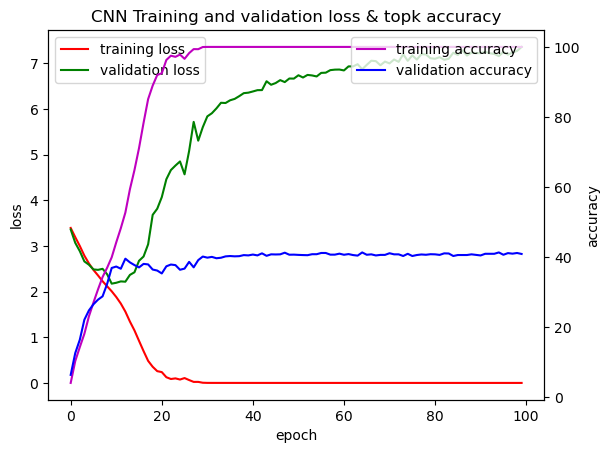

MLP model has a total of 1487394 trainable parameters
CNN model has a total of 1924434 trainable parameters


In [12]:
# Your graph

plot_model_train_stats(os.getcwd() + "/results/cnnclassifier.pt",
                       "roc_cnn.svg",
                       "CNN Training and validation loss & topk accuracy")

#The Quiestion below asks for the number of params 
mlp_parameters = filter(lambda p: p.requires_grad, mlp_net.parameters())
n_params = sum([np.prod(p.size()) for p in mlp_parameters])
print(f"MLP model has a total of {n_params} trainable parameters")

cnn_parameters = filter(lambda p: p.requires_grad, cnn_net.parameters())
n_params = sum([np.prod(p.size()) for p in cnn_parameters])
print(f"CNN model has a total of {n_params} trainable parameters")

> Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

Both CNN and MLP models are fully connected and take a 64x63 image as an input, with 3 color channel respectively. The output is the predicted class out of 30 however both models differ in their structure and performance. The MLP model consists of 2 linear hidden layers with 120 and 84 neuron nodes respectivly.The activation function used cor the neurtions is a relu(Rectifed linear unit) and has a total of X trainable parameters.

The CNN model has 2 convolution layers with 40 kernals in the first layer and 80 in the second. Both the kernals are 3x3 and the output of the first convolution layer is a 2x2 max pooled. This is followed by 2 relu activated linear hidden layers with 120 and 84 neurons respectively. The CNN model has a total of X parameter. The CNN model is twice as accurate in classifying images compared to the MLP model this is becouse convolutions can extract spacial features as they compute the weighted sum of valuesin its receptive window into a single value, another advantage to this is that the individual convolution layer output will not be affected by the changes of pixel values outside its receptive window.Compared to the MLP model the combining of layers when using a CNN model allows the model to extract larger features in images such as the eyes,head and tail of an animal. 

In summary a CNN model are by nature specialized for tasks involving image data where spiatal relationships are crucial which makes them more suitable on the tinyimage30 dataset. MLPS also have their uses as they are more versatile and can be applied to a wider range of tasks and datatypes however for the activity we are doing the CNN would give significantly better results.

### 2.2 Generating confusion matrix and ROC curves (6 marks)
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

Confusion matrix evaluated on training set.
Each entry indicates percent from total.

[[3.35 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   3.37 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   3.44 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   3.35 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   3.33 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   3.43 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.

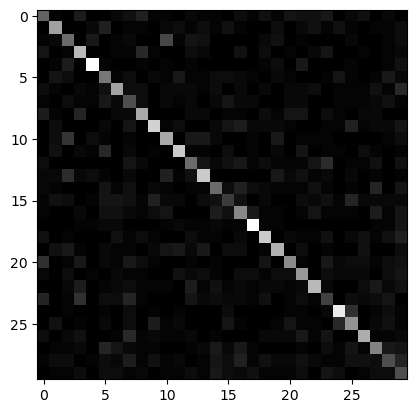

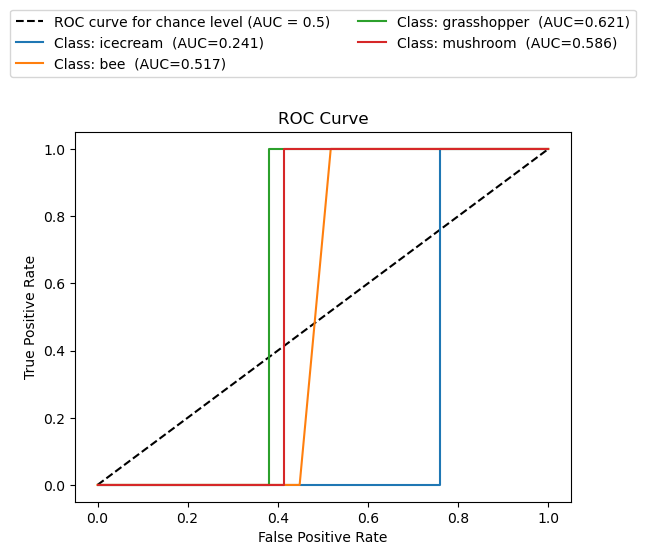

In [24]:
#We first need to generate 2 confusation matrices for the training and validation set respectively 
#Display a ROC curve for the two top and bottom classes with area under the curve

def generate_cnfm(net, loader, n, results_path):
    d = torch.load(results_path)
    net.load_state_dict(d["state_dict"])

    classes = np.arange(0, n)
    nclasses = classes.shape[0]
    cnfm = np.zeros((nclasses, nclasses), dtype=float)

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)    

            for i in range(labels.size(0)):
                cnfm[labels[i].item(), predicted[i].item()] += 1

    return cnfm

def conv_cnfm_percent(cnfm):
    nentries = cnfm.sum((0,1))
    percent_from_total = (1 / nentries) * 100
    return(cnfm * percent_from_total)

def display_cnfm(cnfm, title: str="Confusion matrix on model", gray_map=True):
    print(title)
    print("Each entry indicates percent from total.")
    print()
    np.set_printoptions(precision=2)
    print(conv_cnfm_percent(cnfm))

    if gray_map:
        print()
        print("Grey scale mapping of the confusion matrix.")
        gray_map = plt.imshow(cnfm, cmap='gray')

def get_top_bottom_classes(cnfm):
    correct = np.diag(cnfm)
    top5_idx = correct.argsort()[::-1][:5]
    bottom5_idx = correct.argsort()[:5]
    return top5_idx, bottom5_idx

def calc_y_probs(cnfm, nclasses):
    y_probs = np.zeros((nclasses), dtype=float)
    frac_cnfm = (conv_cnfm_percent(cnfm) / 100)
    for i in range(nclasses):
        y_probs[i] = frac_cnfm[i][:].sum()
    return y_probs

def display_roc(cnfm, nclasses, top_classes, bottom_classes):
    y = np.arange(0, nclasses)
    y_probs = calc_y_probs(cnfm, nclasses)

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--', label="ROC curve for chance level (AUC = 0.5)")

    for idx in [top_classes[0], top_classes[1], bottom_classes[0], bottom_classes[1]]:
        fpr, tpr, thresholds = roc_curve(y, y_probs, pos_label=idx)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Class: {CLASS_TXT_LABELS[idx]}  (AUC={roc_auc:.3f})")

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=2,
    )
    plt.show()

net = CNNClassifier()

train_set = LoadTinyImage30TrainSet()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)
train_cnfm = generate_cnfm(net, train_loader, nclasses, os.getcwd() + "/results/cnnclassifier.pt")
val_cnfm = generate_cnfm(net, validation_loader, nclasses, os.getcwd() + "/results/cnnclassifier.pt")

# Determine top and bottom classes
top_classes, bottom_classes = get_top_bottom_classes(val_cnfm)

# Display confusion matrices
display_cnfm(cnfm=train_cnfm, title="Confusion matrix evaluated on training set.")
display_cnfm(cnfm=val_cnfm, title="Confusion matrix evaluated on validation set.")

# Display ROC curves
display_roc(cnfm=val_cnfm, nclasses=30, top_classes=top_classes, bottom_classes=bottom_classes)


### Redesign your CNN model (optional)
> This is optional and does not carry any marks. Often to tackle model underfitting we tend to make more complex network design. Depending on your observation, you can improve your model if you wish. 

In [ ]:
# Your code here (optional)

**Note: All questions below here relates to the CNN model only and not an MLP model! You are advised to use your final CNN model only for each of the questions below.**

### 2.3 Strategies for tackling overfitting (18 marks)
Using your (final) CNN model perform the strategies below to avoid overfitting problems. You can resuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation (6 marks)

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graphs and comment on what you observe.


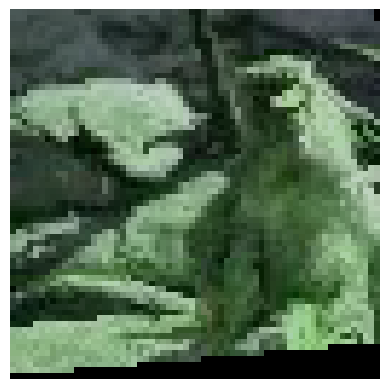

CNNClassifier(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)
Epoch 0 		 training loss:  3.195
Epoch 0 		 training topk accuracy:  17.274
Epoch 0 		 new validation accuracy maximum  26.417
Epoch 1 		 training loss:  2.604
Epoch 1 		 training topk accuracy:  26.239
Epoch 1 		 new validation accuracy maximum  35.296
Epoch 2 		 training loss:  2.445
Epoch 2 		 training topk accuracy:  29.937
Epoch 3 		 training loss:  2.325
Epoch 3 		 training topk accuracy:  32.877
Epoch 3 		 new validation accuracy maximum  38.033
Epoch 4 		 training loss:  2.249
Epoch 4 		 training topk accuracy:  35.346
Epoch 4 		 new validation accuracy maximum  39.583
Epoch 5 

Epoch 87 		 training loss:  1.002
Epoch 87 		 training topk accuracy:  68.944
Epoch 88 		 training loss:  1.046
Epoch 88 		 training topk accuracy:  67.909
Epoch 89 		 training loss:  1.044
Epoch 89 		 training topk accuracy:  67.647
Epoch 90 		 training loss:  1.003
Epoch 90 		 training topk accuracy:  68.155
Epoch 91 		 training loss:  1.010
Epoch 91 		 training topk accuracy:  69.027
Epoch 92 		 training loss:  1.002
Epoch 92 		 training topk accuracy:  69.379
Epoch 93 		 training loss:  1.001
Epoch 93 		 training topk accuracy:  69.006
Epoch 94 		 training loss:  0.990
Epoch 94 		 training topk accuracy:  69.446
Epoch 95 		 training loss:  0.993
Epoch 95 		 training topk accuracy:  69.348
Epoch 96 		 training loss:  0.982
Epoch 96 		 training topk accuracy:  69.573
Epoch 97 		 training loss:  0.989
Epoch 97 		 training topk accuracy:  68.947
Epoch 98 		 training loss:  0.978
Epoch 98 		 training topk accuracy:  69.456
Epoch 99 		 training loss:  0.971
Epoch 99 		 training topk accu

In [29]:
# tensor augmentation strategy to use for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2), 
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.1),
    transforms.RandomAutocontrast(p=0.1)
])

# the same training set, but this time introduce augmentation during training  
train_set = LoadTinyImage30TrainSet(transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

#it doesnt show the epocs so printing an image to ensure it passed this part of the code
data, label = train_set[100]
aug_img = timshow(data)

# fine tune the most accurate CNN model with augmentations
aug_net = CNNClassifier()
checkpoint = torch.load(os.getcwd() + "/results/cnnclassifier.pt")
aug_net.load_state_dict(checkpoint['state_dict']) # load the state of the most accurate cnn

aug_loss_fn = nn.CrossEntropyLoss()
aug_optimizer = optim.SGD(aug_net.parameters(), lr=0.01, momentum=0.9)
print(aug_net)
train_model(100, aug_net, aug_loss_fn, aug_optimizer, ROOT, "augmented_cnnclassifier")

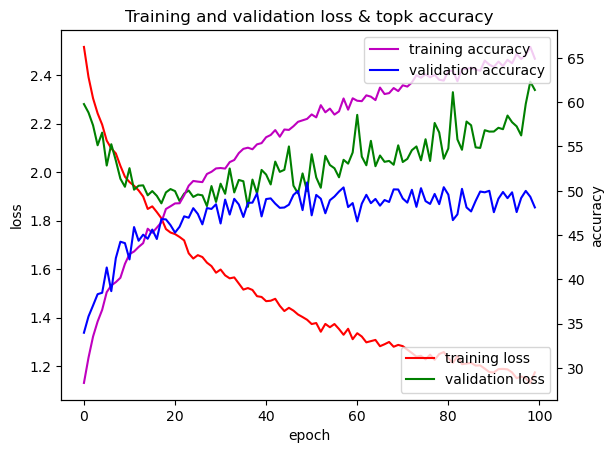

The graphical representation of the training and validation loss, along with the accuracy metrices from the argumented CNN model reveals some interesting observations. Initally the validation accuract exhibits rapid improvements across epochs demonstrting an ascent to approximately 50 percent thus surpassing the validation accuracy of the unargumented CNN model by 12 percentage points(39 percent).Moreover the validation loss shows a declining trend until a certain thereshold thereafter showing a gradual increase which is indicative of potential overfitting despite intergrating augmentation techniques.

These observations collectively suggest that the amalgamation of five augmentation strategies, encompassing both photometric and geometric transformations, notably enhances the generalization capacity of the CNN model from the previous cell (Q2.1). This enhancement is attributed to the heightened variability and adaptability conferred upon the model by the diverse augmentation techniques. Consequently, the model showcases improved predictive accuracy on unseen images, mitigating the risk of overfitting and thereby bolstering its generalization prowess.

#### 2.3.2 Dropout (6 marks)

> Implement dropout in your model 

> Provide graphs and comment on your choice of proportion used.

In [45]:
class Dropout_CNNClassifier(nn.Module):
    
    def __init__(self, num_classes=30): # TinyImage30 data contains 30 class labels
        super(Dropout_CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=40,kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=40,out_channels=80,kernel_size=3)
        self.fc1 = nn.Linear(15680, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)
        
        # Droput 25 % of neurons
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
dropout_net = Dropout_CNNClassifier()
dropout_loss_fn = nn.CrossEntropyLoss()
dropout_optimizer = optim.SGD(dropout_net.parameters(), lr=0.01, momentum=0.9)
print(dropout_net)   

checkpoint = torch.load(os.getcwd() + "/results/cnnclassifier.pt")
dropout_net.load_state_dict(checkpoint['state_dict']) # load the state of the most accurate cnn

# the same training set, but this time exclude augmentation during training  
train_set = LoadTinyImage30TrainSet()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

train_model(100, dropout_net, dropout_loss_fn, dropout_optimizer, ROOT, "dropout_cnnclassifier")

Dropout_CNNClassifier(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Epoch 0 		 training loss:  0.661
Epoch 0 		 training topk accuracy:  79.891
Epoch 0 		 new validation accuracy maximum  37.403
Epoch 1 		 training loss:  0.074
Epoch 1 		 training topk accuracy:  97.994
Epoch 1 		 new validation accuracy maximum  37.633
Epoch 2 		 training loss:  0.013
Epoch 2 		 training topk accuracy:  99.750
Epoch 2 		 new validation accuracy maximum  38.675
Epoch 3 		 training loss:  0.004
Epoch 3 		 training topk accuracy:  99.917
Epoch 3 		 new validation accuracy maximum  40.177
Epoch 4 		 training loss:  0.001

Epoch 93 		 training loss:  0.000
Epoch 93 		 training topk accuracy:  100.000
Epoch 94 		 training loss:  0.000
Epoch 94 		 training topk accuracy:  100.000
Epoch 95 		 training loss:  0.000
Epoch 95 		 training topk accuracy:  100.000
Epoch 96 		 training loss:  0.000
Epoch 96 		 training topk accuracy:  100.000
Epoch 97 		 training loss:  0.000
Epoch 97 		 training topk accuracy:  100.000
Epoch 98 		 training loss:  0.000
Epoch 98 		 training topk accuracy:  100.000
Epoch 99 		 training loss:  0.000
Epoch 99 		 training topk accuracy:  100.000


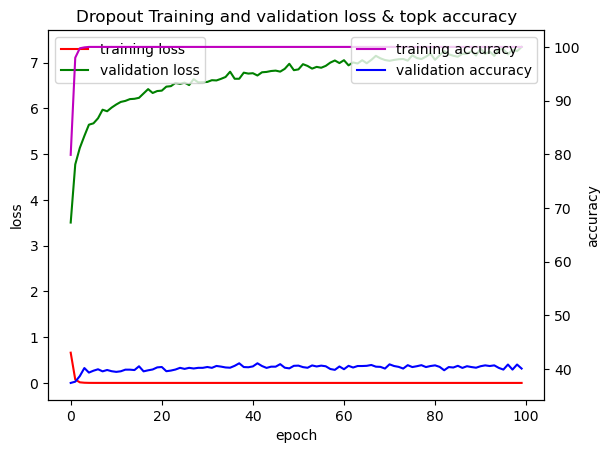

In [46]:
plot_model_train_stats(os.getcwd() + "/results/dropout_cnnclassifier.pt", 
                       "roc_dcnn.svg",
                      "Dropout Training and validation loss & topk accuracy")

#### 2.3.3 Hyperparameter tuning (6 marks)

> Use learning rates [0.1, 0.001, 0.0001].

> Provide graphs each for loss and accuracy at three different learning rates in a single graph.

In [32]:
# Your code here!

In [33]:
# Your graph

### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set. 

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks)


#### 3.1 Test class and predictions (4 marks)

> Build a test class, prepare a test dataloader and generate predictions

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [34]:
# Your code here!

#### 3.2 Prepare your submission and upload to Kaggle  (6 marks)

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, e.g., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers. [To submit please click here.](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [6 marks]. 


In [35]:
# Your code here! 


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [16 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [36]:
# Your code here! 

> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [37]:
# Your code here! 

#### 4.1 Apply transfer learning with pretrained model weights (6 marks)


> Configuration 1: No frozen layers

In [38]:
# Your model changes here - also print trainable parameters

#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [39]:
# Your changes here - also print trainable parameters

#### 4.3 Compare above configurations and comment on performances. (4 marks)

In [40]:
# Your graphs here and please provide comment in markdown in another cell

### Part II: Image Captioning using RNN [30 marks]



### Motivation 

Through this part of assessment you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)" but our image subset consists of fewer images compared to orginial COCO dataset. So, no need to download anything from here! 

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.

#### Submission

You can either submit the same file or make a two separate .ipython notebook files zipped in the submission (please name as ``yourstudentusername_partI.ipynb`` and ``yourstudentusername_partII.ipynb``). 

**Final note:**

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you fine-tuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->

<div>
<center><img src="comp5625M_figure.jpg" width="1000"/></center>
</div>


### Instructions for creating vocabulary 

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [41]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


**Please refer to the submission section at the top of this notebook to prepare your submission.**


In [43]:
# Load the feature map provided to you
features_map = torch.load('coco_features_'+(device.type)+'.pt', map_location=device)

FileNotFoundError: [Errno 2] No such file or directory: 'coco_features_cpu.pt'

#### 5 Train DecoderRNN [20 marks]

> 5.1 Design a RNN-based decoder (10 marks)

> 5.2 Train your model with precomputed features (10 Marks)

##### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
import json
import pandas as pd

with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

In [ ]:
coco_subset = pd.read_csv("coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

In [ ]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

In [ ]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

In [ ]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
### build vocabulariy for each set - train, val and test 
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


In [ ]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our 
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 


In [ ]:
from helperDL import EncoderCNN  
model = EncoderCNN() 
print(model)

In [ ]:
''' Load the saved image feature maps and trained model ("provided to you") '''

# ---> your entry here (make sure that the path is correct)
features = torch.load("coco_features.pt")

# also load the model ckpt and udate the model state dict of the base model
# ---> your entry here (make sure that the path is correct)
checkpoint = torch.load("ckpt file here") 
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [ ]:
# say this is as below 
# --> Please change these numbers as required. 
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        # your code
        
        # batch normalisation helps to speed up training
        # your code


        # your code for embedding layer
   

        # your code for RNN
   

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        # compute your feature embeddings
        # your code

    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
    


        outputs = self.linear() #hint: use a hidden layers in parenthesis
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

##### 5.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:

# loss and optimizer here
# your code here --->



# train the models
total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->









  
        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")
    
    stats[epoch,0] = round(total_loss/total_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():  
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->



            
    stats[epoch,1] = round(total_loss/total_step_v,3)
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

In [ ]:
fig = plt.figure()

plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [ ]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation [10 marks] 

#### 6.1 Generate predictions on test data (4 marks)

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
data_transform = transforms.Compose([ 
    transforms.Resize(224),     
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [ ]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

In [ ]:
# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption

In [ ]:
IMAGES_TO_SHOW = 4
idx = 0
with torch.no_grad():
    for i, (image,filename) in enumerate(test_loader):
        
        # your code here --->







        
        print(f"GENERATED: \n")
        print("REFERENCES:")

        print("===================================\n")


        timshow(image[0].cpu())
        idx +=1
        if idx == IMAGES_TO_SHOW:
            break

#### 6.2 Caption evaluation using cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
# your code here

##### Thank you for completing the assessment - if you have any question, please ask on teams channel or attend lab sessions on Tuesdays and Wednesdays.